In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

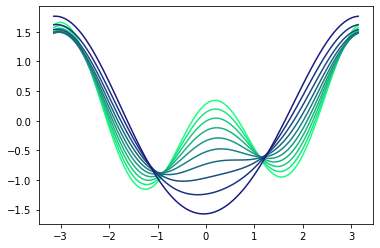

In [2]:
N = 101
phi = t.linspace(-np.pi,np.pi,N)
dphi = t.mean(phi[1:] - phi[:-1]).item()

def V(phi,alpha=1):
    return -1/(0.5+alpha)*t.cos(phi) + alpha*t.cos(2*phi - 0.1*np.pi)

fig, ax = plt.subplots()
for alpha in np.arange(1,0,-0.1):
    ax.plot(phi,V(phi,alpha),c=(0.1,alpha,0.5))

In [163]:
class System(t.nn.Module):
    def __init__(self, phi, T, NTrot):
        super(System,self).__init__()
        self.prepare_KinE()
        self.T = T
        self.NTrot = NTrot
        
        self.times = t.linspace(0,T,self.NTrot)
        self.dt = (self.times[1:] - self.times[:-1]).mean().item()
        self.Id = t.diag(t.ones(self.Kinetic_energy.shape[0],dtype=t.complex128))
        
        self.decline_end = t.nn.parameter.Parameter(t.tensor(0.25*self.T))
        self.ascend_start = t.nn.parameter.Parameter(t.tensor(0.75*self.T))
        self.ReLU = t.nn.ReLU()
        
    def forward(self):
        out = self.Id
        for n in range(self.NTrot):
            out = t.matmul(t.matrix_exp(-1j*self.get_H(self.activation_func(self.times[n]))*self.dt),out)
        return out
    
#     def forward(self):
#         H = self.Kinetic_energy.repeat((self.NTrot,1,1)) \
#             + t.diag_embed(V(phi.unsqueeze(0),self.activation_func(self.times).unsqueeze(1))).type(t.complex128)
#         return t.linalg.multi_dot([mat for mat in t.matrix_exp(-1j*H*self.dt)])
            
    def activation_func(self,time):
        return self.ReLU(self.decline_end - time)/self.decline_end + self.ReLU(time - self.ascend_start)/(self.T - self.ascend_start)
    
    def prepare_KinE(self):
        double_diff = (t.diag(-2*t.ones(N)) + t.diag(t.ones(N-1),1) + t.diag(t.ones(N-1),-1)).type(t.complex128)
        dphi = (phi[1:] - phi[:-1]).mean().item()
        self.Kinetic_energy = -1/dphi**2*double_diff
        return
    
    def get_H(self,alpha=1):
        return self.Kinetic_energy + t.diag(V(phi,alpha)).type(t.complex128)

In [164]:
S1 = System(phi,30,91)
# S1_traced = t.jit.trace(S1,t.rand(10))

In [160]:
def timeit(func,N):
    from time import time
    start = time()
    for _ in range(N):
        func()
    end = time()
    print(end-start)
    return

In [127]:
timeit(lambda: S1_traced(None),100)

20.50544047355652


In [128]:
timeit(S1,100)

20.827998638153076


In [49]:
timeit(S1,100)

26.420517683029175


# Seems to be faster to batch it, and at any rate it doesn't seem to improve by jitting it

In [162]:
#Batched:
timeit(S1,500)

174.31580996513367


In [165]:
#Non-batched
timeit(S1,500)

253.86560726165771
